# PSO-Optimized DistilBERT for Financial Sentiment Classification

This notebook implements Particle Swarm Optimization (PSO) for hyperparameter tuning of DistilBERT on the **complete Financial PhraseBank dataset** (4,840 sentences).

**Key Updates for Final Project:**
- Using complete dataset (all agreement levels: 50%, 66%, 75%, 100%)
- PSO: 10 particles × 10 iterations = 100 evaluations (~13 hours)
- Comprehensive analysis: learning curves, error analysis, statistical testing
- Comparison across data subsets (AllAgree vs Full dataset)

**Computational Notes:**
- Hardware: CPU-only (MacBook Pro)
- Estimated runtime: ~15-18 hours total (PSO + final training + evaluation)
- Save checkpoints regularly to prevent data loss

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pyswarms as ps
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

Using device: cpu


## Cell 2: Load Complete Financial PhraseBank Dataset

**Dataset:** FinancialPhraseBankDataset.csv
- Total sentences: 4,840
- Classes: Negative, Neutral, Positive
- Agreement levels: 50%, 66%, 75%, 100% (all included)

**Expected challenges:**
- More class imbalance than AllAgree subset
- Noisier labels (some sentences have only 50% annotator agreement)
- Lower baseline accuracy expected (vs 95% on AllAgree)

**Data format:**
- Column 1: Text (financial sentences)
- Column 2: Sentiment (negative/neutral/positive)

In [40]:
df = pd.read_csv('/Users/zhuwenxuan/Desktop/STAT 507/final project/data/FinancialPhraseBankDataset.csv',
                  encoding="latin-1")

print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
# print(df.head())

# missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Rename columns
df = df.rename(columns={'sentence': 'text', 'label': 'label'})

# Check for any NaN in labels
if df['label'].isnull().any():
    print(f"\n Warning: {df['label'].isnull().sum()} rows have missing labels!")
    print("Removing rows with missing labels...")
    df = df.dropna(subset=['label'])
    print(f"After removal: {df.shape}")
else:
    print("\n✓ All rows have valid labels")

print(f"\nTotal samples: {len(df)}")

# create a 'sentiment' column 
# (mapping numbers back to text for display purposes only)
label_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['sentiment'] = df['label'].map(label_to_sentiment)

print(f"\nFinal columns: {df.columns.tolist()}")
print(f"\nSample data:")
print(df[['text', 'label', 'sentiment']].head())

Dataset shape: (4846, 3)
Column names: ['Unnamed: 0', 'sentence', 'label']

Missing values:
Unnamed: 0    0
sentence      0
label         0
dtype: int64

✓ All rows have valid labels

Total samples: 4846

Final columns: ['Unnamed: 0', 'text', 'label', 'sentiment']

Sample data:
                                                text  label sentiment
0  According to Gran , the company has no plans t...      1   neutral
1  Technopolis plans to develop in stages an area...      1   neutral
2  The international electronic industry company ...      0  negative
3  With the new production plant the company woul...      2  positive
4  According to the company 's updated strategy f...      2  positive


## Cell 3: Create PyTorch Dataset Class

**FinancialSentimentDataset:**
- Handles tokenization with DistilBERT tokenizer
- Max length: 128 tokens (sufficient for financial sentences)
- Padding: Pad shorter sequences to max_length
- Truncation: Truncate longer sequences
- Returns: input_ids, attention_mask, labels

In [41]:
class FinancialSentimentDataset(Dataset):
    """
    PyTorch Dataset for Financial Sentiment Classification
    
    Args:
        texts (list): List of financial sentences
        labels (list): List of sentiment labels (0=negative, 1=neutral, 2=positive)
        tokenizer: DistilBERT tokenizer
        max_length (int): Maximum sequence length
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Cell 4: Prepare & Split Data

**Splitting strategy:**
- 70% Train: 3,388 samples (for model training)
- 10% Validation: 484 samples (for hyperparameter selection & early stopping)
- 20% Test: 968 samples (for final evaluation)

**Stratification:** Maintain class distribution across all splits

**Note:** Using full dataset, so expect different class distributions than AllAgree subset.

In [42]:
# Split data: 70% train, 10% val, 20% test (stratified)
# 1st split: 80% train+val, 20% test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.20,
    random_state=SEED,
    stratify=df['label'].values
)

# 2nd split: 87.5% train, 12.5% val (of the 80%)
## so 70% train (0.875 * 0.80 = 0.70) and 10% val (0.125 * 0.80 = 0.10)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.125,
    random_state=SEED,
    stratify=train_val_labels
)

print("Dataset split:")
print(f"  Train: {len(train_texts)} samples")
print(f"  Val:   {len(val_texts)} samples")
print(f"  Test:  {len(test_texts)} samples")

# Check class distribution in each split
print("\nClass distribution:")
for split_name, labels in [('Train', train_labels), ('Val', val_labels), ('Test', test_labels)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name}:")
    for label, count in zip(unique, counts):
        label_name = ['Negative', 'Neutral', 'Positive'][label]
        percentage = (count / len(labels)) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# PyTorch datasets
train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = FinancialSentimentDataset(test_texts, test_labels, tokenizer)

# Sample check
print("\nSample check:")
sample = train_dataset[0]
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Label: {sample['label']}")

Dataset split:
  Train: 3391 samples
  Val:   485 samples
  Test:  970 samples

Class distribution:

Train:
  Negative: 422 (12.4%)
  Neutral: 2015 (59.4%)
  Positive: 954 (28.1%)

Val:
  Negative: 61 (12.6%)
  Neutral: 288 (59.4%)
  Positive: 136 (28.0%)

Test:
  Negative: 121 (12.5%)
  Neutral: 576 (59.4%)
  Positive: 273 (28.1%)

Sample check:
  Input IDs shape: torch.Size([128])
  Attention mask shape: torch.Size([128])
  Label: 1


## Cell 5: Training & Evaluation Functions

**Key functions:**
1. `train_epoch()`: Train for one epoch
2. `evaluate()`: Evaluate on validation/test set
3. `train_model()`: Complete training loop with early stopping

**Early stopping:**
- Patience: 3 epochs
- Monitor: Validation accuracy
- Saves best model based on validation performance

**Gradient clipping:** Max norm = 1.0 to prevent exploding gradients

In [43]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """
    Train model for one epoch
    
    Args:
        model: DistilBERT model
        dataloader: Training data loader
        optimizer: AdamW optimizer
        scheduler: Learning rate scheduler
        device: torch.device
    
    Returns:
        avg_loss (float): Average training loss
        accuracy (float): Training accuracy
    """
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy


def evaluate(model, dataloader, device):
    """
    Evaluate model on validation/test set
    
    Args:
        model: DistilBERT model
        dataloader: Validation/test data loader
        device: torch.device
    
    Returns:
        avg_loss (float): Average loss
        accuracy (float): Accuracy
        predictions (list): Predicted labels
        true_labels (list): True labels
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels


def train_model(model, train_loader, val_loader, optimizer, scheduler, device, 
                num_epochs=10, patience=3, model_name="model"):
    """
    Complete training loop with early stopping
    
    Args:
        model: DistilBERT model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: AdamW optimizer
        scheduler: Learning rate scheduler
        device: torch.device
        num_epochs (int): Maximum number of epochs
        patience (int): Early stopping patience
        model_name (str): Name for saving best model
    
    Returns:
        history (dict): Training history
        best_model_state (dict): Best model state dict
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Starting training...\n")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        
        # Validate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print("✓ New best model!")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s)")
        
        print()
        
        # Stop if patience exceeded
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return history, best_model_state

## Cell 6: Train Baseline Model

**Baseline configuration:**
- Model: DistilBERT-base-uncased (66M parameters)
- Learning rate: 2e-5 (standard for BERT fine-tuning)
- Dropout: 0.3
- Batch size: 16
- Optimizer: AdamW with linear warmup
- Max epochs: 10 (with early stopping patience=3)

**Expected performance on full dataset:**
- Test accuracy: 82-86% (vs 95% on AllAgree subset)
- Lower than AllAgree due to noisier labels

**Runtime:** ~15-20 minutes on CPU

In [44]:
print("="*60)
print("TRAINING BASELINE MODEL ON FULL DATASET")
print("="*60)

# Baseline hyperparameters
baseline_config = {
    'learning_rate': 2e-5,
    'dropout_rate': 0.3,
    'batch_size': 16,
    'num_epochs': 10,
    'patience': 3
}

print("Baseline configuration:")
for key, value in baseline_config.items():
    print(f"  {key}: {value}")
print()

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=baseline_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=baseline_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=baseline_config['batch_size'])

# Initialize model
baseline_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=baseline_config['dropout_rate']
)
baseline_model.to(device)

# Setup optimizer and scheduler
optimizer = AdamW(baseline_model.parameters(), lr=baseline_config['learning_rate'])
total_steps = len(train_loader) * baseline_config['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Train model
baseline_history, baseline_best_state = train_model(
    baseline_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    num_epochs=baseline_config['num_epochs'],
    patience=baseline_config['patience'],
    model_name="baseline"
)

# Evaluate on test set
print("="*60)
print("BASELINE MODEL - TEST EVALUATION")
print("="*60)
print()

baseline_test_loss, baseline_test_acc, baseline_preds, baseline_labels = evaluate(
    baseline_model, test_loader, device
)

print(f"Test Accuracy: {baseline_test_acc*100:.2f}%")
print(f"Test Loss: {baseline_test_loss:.4f}")
print()

# Save baseline results
baseline_results = {
    'config': baseline_config,
    'history': baseline_history,
    'test_acc': baseline_test_acc,
    'test_loss': baseline_test_loss,
    'predictions': baseline_preds,
    'true_labels': baseline_labels,
    'model_state': baseline_best_state
}

print("✓ Baseline model training complete!")
print(f"\nExpected: Full dataset typically gives 82-86% accuracy")
print(f"Achieved: {baseline_test_acc*100:.2f}%")

TRAINING BASELINE MODEL ON FULL DATASET
Baseline configuration:
  learning_rate: 2e-05
  dropout_rate: 0.3
  batch_size: 16
  num_epochs: 10
  patience: 3



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/10
--------------------------------------------------


Train Loss: 0.8674, Train Acc: 0.5954
Val Loss: 0.6139, Val Acc: 0.7485
✓ New best model!

Epoch 2/10
--------------------------------------------------


Train Loss: 0.4685, Train Acc: 0.8145
Val Loss: 0.4016, Val Acc: 0.8412
✓ New best model!

Epoch 3/10
--------------------------------------------------


Train Loss: 0.3096, Train Acc: 0.8862
Val Loss: 0.4218, Val Acc: 0.8330
No improvement for 1 epoch(s)

Epoch 4/10
--------------------------------------------------


Train Loss: 0.2222, Train Acc: 0.9204
Val Loss: 0.5331, Val Acc: 0.8392
No improvement for 2 epoch(s)

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1661, Train Acc: 0.9460
Val Loss: 0.5469, Val Acc: 0.8495
✓ New best model!

Epoch 6/10
--------------------------------------------------


Train Loss: 0.1293, Train Acc: 0.9602
Val Loss: 0.5570, Val Acc: 0.8474
No improvement for 1 epoch(s)

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0979, Train Acc: 0.9696
Val Loss: 0.6894, Val Acc: 0.8536
✓ New best model!

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0764, Train Acc: 0.9776
Val Loss: 0.7204, Val Acc: 0.8474
No improvement for 1 epoch(s)

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0627, Train Acc: 0.9823
Val Loss: 0.7542, Val Acc: 0.8474
No improvement for 2 epoch(s)

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0544, Train Acc: 0.9844
Val Loss: 0.7547, Val Acc: 0.8536
No improvement for 3 epoch(s)

Early stopping at epoch 10
BASELINE MODEL - TEST EVALUATION



Test Accuracy: 83.81%
Test Loss: 0.8099

✓ Baseline model training complete!

Expected: Full dataset typically gives 82-86% accuracy
Achieved: 83.81%


## Cell 7: PSO Hyperparameter Optimizer

**PSO Algorithm:**
- Simulates particle swarm behavior
- Each particle represents a hyperparameter configuration
- Particles move through search space influenced by:
  - Personal best position (cognitive component, c1)
  - Global best position (social component, c2)
  - Inertia (w)

**Search space:**
- Learning rate: [1e-5, 1e-3] (log scale)
- Dropout rate: [0.2, 0.5]
- Hidden layer size: [64, 512]

**PSO parameters:**
- c1 (cognitive): 2.0
- c2 (social): 2.0
- w (inertia): 0.9

**Fitness function:**
- Negative validation accuracy (PSO minimizes, we want to maximize accuracy)
- Uses 5 epochs with early stopping for faster evaluation

In [45]:
class HyperparameterOptimizer:
    """
    PSO-based hyperparameter optimizer for DistilBERT
    
    Optimizes: learning_rate, dropout_rate, hidden_layer_size
    """
    def __init__(self, train_dataset, val_dataset, device):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device
        self.evaluation_count = 0
        self.best_accuracy = 0
        self.best_params = None
        self.history = []
        
    def decode_params(self, x):
        """
        Decode PSO particle position to hyperparameters
        
        Args:
            x (array): [lr, dropout, hidden_size]
        
        Returns:
            dict: Hyperparameter dictionary
        """
        return {
            'learning_rate': float(x[0]),
            'dropout_rate': float(x[1]),
            'hidden_size': int(x[2])
        }
    
    def evaluate_params(self, params):
        """
        Evaluate a hyperparameter configuration
        
        Args:
            params (dict): Hyperparameters
        
        Returns:
            float: Validation accuracy
        """
        self.evaluation_count += 1
        
        print(f"\nEvaluation {self.evaluation_count}:")
        print(f"  LR={params['learning_rate']:.2e}, Dropout={params['dropout_rate']:.3f}, Hidden={params['hidden_size']}")
        
        # Create model
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=3,
            dropout=params['dropout_rate']
        )
        model.to(self.device)
        
        # Create data loaders
        train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=16)
        
        # Setup optimizer
        optimizer = AdamW(model.parameters(), lr=params['learning_rate'])
        total_steps = len(train_loader) * 5  # 5 epochs for PSO evaluation
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )
        
        # Train for 5 epochs (faster evaluation)
        history, _ = train_model(
            model,
            train_loader,
            val_loader,
            optimizer,
            scheduler,
            self.device,
            num_epochs=5,
            patience=2,
            model_name=f"pso_eval_{self.evaluation_count}"
        )
        
        # Get best validation accuracy
        val_acc = max(history['val_acc'])
        
        # Update best
        if val_acc > self.best_accuracy:
            self.best_accuracy = val_acc
            self.best_params = params.copy()
            print(f"  ✓ New best! Accuracy: {val_acc:.4f}")
        
        # Save to history
        self.history.append({
            'eval': self.evaluation_count,
            'params': params.copy(),
            'val_acc': val_acc
        })
        
        return val_acc
    
    def objective_function(self, x):
        """
        PSO objective function (to minimize)
        
        Args:
            x (array): Particle positions (n_particles, n_dimensions)
        
        Returns:
            array: Negative validation accuracies
        """
        n_particles = x.shape[0]
        fitness = np.zeros(n_particles)
        
        for i in range(n_particles):
            params = self.decode_params(x[i])
            val_acc = self.evaluate_params(params)
            fitness[i] = -val_acc  # Negative because PSO minimizes
        
        return fitness

print("✓ PSO Optimizer class defined")

✓ PSO Optimizer class defined


## Cell 8: Run PSO Optimization (10 particles × 10 iterations)

**Expected outcome:**
- Find better hyperparameters than baseline
- Target: 1-3% improvement over baseline on full dataset
- Non-intuitive combinations (like very low LR) may emerge

In [46]:
# Record start time
start_time = datetime.now()
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print()

print("⚠️  Starting PSO optimization...")
print("    This will take approximately 13 hours!")
print("    10 particles × 10 iterations = 100 evaluations")
print()

# Create optimizer
hp_optimizer = HyperparameterOptimizer(train_dataset, val_dataset, device)

# Define search space bounds
# [learning_rate, dropout_rate, hidden_size]
min_bound = np.array([1e-5, 0.2, 64])
max_bound = np.array([1e-3, 0.5, 512])
bounds = (min_bound, max_bound)

# PSO parameters
pso_config = {
    'n_particles': 10,
    'iters': 10,
    'c1': 2.0,  # cognitive component
    'c2': 2.0,  # social component
    'w': 0.9    # inertia weight
}

print("="*60)
print("STARTING PSO HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"Particles: {pso_config['n_particles']}")
print(f"Iterations: {pso_config['iters']}")
print(f"Total evaluations: {pso_config['n_particles'] * pso_config['iters']}")
print(f"PSO parameters: c1={pso_config['c1']}, c2={pso_config['c2']}, w={pso_config['w']}")
print()
print("Search space:")
print(f"  Learning Rate: [{min_bound[0]:.0e}, {max_bound[0]:.0e}]")
print(f"  Dropout Rate: [{min_bound[1]}, {max_bound[1]}]")
print(f"  Hidden Size: [{int(min_bound[2])}, {int(max_bound[2])}]")
print("="*60)
print()

# Initialize PSO optimizer
options = {'c1': pso_config['c1'], 'c2': pso_config['c2'], 'w': pso_config['w']}
optimizer = ps.single.GlobalBestPSO(
    n_particles=pso_config['n_particles'],
    dimensions=3,
    options=options,
    bounds=bounds
)

# Run optimization
cost, pos = optimizer.optimize(
    hp_optimizer.objective_function,
    iters=pso_config['iters']
)

# Record end time
end_time = datetime.now()
duration = end_time - start_time

print()
print("="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Duration: {duration}")
print()
print(f"Best Accuracy: {hp_optimizer.best_accuracy:.4f}")
print("Best Hyperparameters:")
for key, value in hp_optimizer.best_params.items():
    if key == 'learning_rate':
        print(f"  {key}: {value:.2e}")
    elif key == 'dropout_rate':
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")
print("="*60)
print()

# Save PSO results
pso_optimization_results = {
    'config': pso_config,
    'best_params': hp_optimizer.best_params,
    'best_accuracy': hp_optimizer.best_accuracy,
    'history': hp_optimizer.history,
    'duration': duration,
    'search_space': {'min': min_bound, 'max': max_bound}
}

# Save checkpoint
with open('pso_optimization_checkpoint.pkl', 'wb') as f:
    pickle.dump(pso_optimization_results, f)

print("✓ PSO optimization complete!")
print(f"Best parameters: {hp_optimizer.best_params}")
print(f"Best validation accuracy: {hp_optimizer.best_accuracy*100:.2f}%")
print(f"\nImprovement over baseline: {(hp_optimizer.best_accuracy - max(baseline_history['val_acc']))*100:.2f} percentage points")

2025-11-16 21:24:31,928 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}


Start time: 2025-11-16 21:24:31

⚠️  Starting PSO optimization...
    This will take approximately 13 hours!
    10 particles × 10 iterations = 100 evaluations

STARTING PSO HYPERPARAMETER OPTIMIZATION
Particles: 10
Iterations: 10
Total evaluations: 100
PSO parameters: c1=2.0, c2=2.0, w=0.9

Search space:
  Learning Rate: [1e-05, 1e-03]
  Dropout Rate: [0.2, 0.5]
  Hidden Size: [64, 512]



pyswarms.single.global_best:   0%|          |0/10


Evaluation 1:
  LR=3.95e-04, Dropout=0.281, Hidden=435


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8383, Train Acc: 0.6435
Val Loss: 0.8493, Val Acc: 0.6784
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.7884, Train Acc: 0.6741
Val Loss: 0.8023, Val Acc: 0.5918
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8505, Train Acc: 0.6234
Val Loss: 0.8351, Val Acc: 0.6680
No improvement for 2 epoch(s)

Early stopping at epoch 3
  ✓ New best! Accuracy: 0.6784

Evaluation 2:
  LR=3.63e-04, Dropout=0.284, Hidden=307


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7615, Train Acc: 0.6771
Val Loss: 0.6403, Val Acc: 0.7732
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6578, Train Acc: 0.7697
Val Loss: 0.7380, Val Acc: 0.6598
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.5028, Train Acc: 0.8413
Val Loss: 0.7877, Val Acc: 0.7649
No improvement for 2 epoch(s)

Early stopping at epoch 3
  ✓ New best! Accuracy: 0.7732

Evaluation 3:
  LR=1.50e-04, Dropout=0.441, Hidden=97


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7062, Train Acc: 0.6921
Val Loss: 0.4464, Val Acc: 0.8206
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4406, Train Acc: 0.8357
Val Loss: 0.4895, Val Acc: 0.7918
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3256, Train Acc: 0.8921
Val Loss: 0.5046, Val Acc: 0.8041
No improvement for 2 epoch(s)

Early stopping at epoch 3
  ✓ New best! Accuracy: 0.8206

Evaluation 4:
  LR=9.87e-04, Dropout=0.432, Hidden=153


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9556, Train Acc: 0.5812
Val Loss: 0.9716, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9445, Train Acc: 0.5936
Val Loss: 0.9420, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9342, Train Acc: 0.5942
Val Loss: 0.9381, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 5:
  LR=1.55e-05, Dropout=0.445, Hidden=380


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8591, Train Acc: 0.5901
Val Loss: 0.6059, Val Acc: 0.7567
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5221, Train Acc: 0.7930
Val Loss: 0.4131, Val Acc: 0.8309
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4024, Train Acc: 0.8464
Val Loss: 0.3953, Val Acc: 0.8206
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3514, Train Acc: 0.8664
Val Loss: 0.3917, Val Acc: 0.8392
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.3204, Train Acc: 0.8812
Val Loss: 0.3965, Val Acc: 0.8351
No improvement for 1 epoch(s)

  ✓ New best! Accuracy: 0.8392

Evaluation 6:
  LR=7.32e-04, Dropout=0.431, Hidden=97


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8850, Train Acc: 0.6140
Val Loss: 0.8820, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8691, Train Acc: 0.6193
Val Loss: 0.9096, Val Acc: 0.5175
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9204, Train Acc: 0.5883
Val Loss: 0.9609, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 7:
  LR=3.65e-04, Dropout=0.235, Hidden=450


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7144, Train Acc: 0.7054
Val Loss: 0.9301, Val Acc: 0.7072
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6297, Train Acc: 0.7868
Val Loss: 0.8508, Val Acc: 0.7485
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4710, Train Acc: 0.8635
Val Loss: 0.6794, Val Acc: 0.7918
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.4176, Train Acc: 0.8797
Val Loss: 0.6948, Val Acc: 0.7753
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.3068, Train Acc: 0.9219
Val Loss: 0.8365, Val Acc: 0.7897
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 8:
  LR=6.27e-04, Dropout=0.299, Hidden=92


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8957, Train Acc: 0.6051
Val Loss: 0.9296, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9494, Train Acc: 0.5942
Val Loss: 0.9368, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9335, Train Acc: 0.5942
Val Loss: 0.9296, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 9:
  LR=3.18e-04, Dropout=0.298, Hidden=390


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7278, Train Acc: 0.6983
Val Loss: 0.7496, Val Acc: 0.7258
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5688, Train Acc: 0.8004
Val Loss: 0.6813, Val Acc: 0.8082
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4143, Train Acc: 0.8826
Val Loss: 0.6741, Val Acc: 0.7938
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2938, Train Acc: 0.9168
Val Loss: 0.7745, Val Acc: 0.7979
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 10:
  LR=6.41e-04, Dropout=0.466, Hidden=275


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8972, Train Acc: 0.6137
Val Loss: 0.9068, Val Acc: 0.6598
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9407, Train Acc: 0.5948
Val Loss: 0.9771, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


pyswarms.single.global_best:  10%|█         |1/10, best_cost=-0.839

Train Loss: 0.9361, Train Acc: 0.5942
Val Loss: 0.9416, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 11:
  LR=4.21e-04, Dropout=0.402, Hidden=420


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8852, Train Acc: 0.6146
Val Loss: 0.9983, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9354, Train Acc: 0.5907
Val Loss: 0.9840, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9373, Train Acc: 0.5942
Val Loss: 0.9281, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 12:
  LR=2.72e-04, Dropout=0.394, Hidden=343


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7284, Train Acc: 0.6898
Val Loss: 0.5671, Val Acc: 0.7918
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5298, Train Acc: 0.8183
Val Loss: 0.7861, Val Acc: 0.7753
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4059, Train Acc: 0.8694
Val Loss: 0.6907, Val Acc: 0.8144
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2618, Train Acc: 0.9245
Val Loss: 0.6485, Val Acc: 0.8124
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1957, Train Acc: 0.9472
Val Loss: 0.7590, Val Acc: 0.8247
✓ New best model!


Evaluation 13:
  LR=1.79e-04, Dropout=0.232, Hidden=232


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6630, Train Acc: 0.7311
Val Loss: 0.4932, Val Acc: 0.8206
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4029, Train Acc: 0.8549
Val Loss: 0.4884, Val Acc: 0.8268
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2217, Train Acc: 0.9289
Val Loss: 0.6222, Val Acc: 0.8124
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1255, Train Acc: 0.9661
Val Loss: 0.7830, Val Acc: 0.8206
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 14:
  LR=6.44e-04, Dropout=0.469, Hidden=441


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9430, Train Acc: 0.5768
Val Loss: 0.9398, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9377, Train Acc: 0.5933
Val Loss: 0.9285, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9311, Train Acc: 0.5969
Val Loss: 0.9296, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 15:
  LR=7.86e-04, Dropout=0.302, Hidden=381


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9028, Train Acc: 0.5998
Val Loss: 0.9054, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8848, Train Acc: 0.5886
Val Loss: 0.8919, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8799, Train Acc: 0.5927
Val Loss: 0.8861, Val Acc: 0.6268
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.8602, Train Acc: 0.6004
Val Loss: 0.8933, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.8585, Train Acc: 0.5969
Val Loss: 0.8927, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 16:
  LR=1.58e-04, Dropout=0.209, Hidden=203


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6814, Train Acc: 0.7098
Val Loss: 0.4874, Val Acc: 0.8289
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3842, Train Acc: 0.8605
Val Loss: 0.4790, Val Acc: 0.8309
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2251, Train Acc: 0.9295
Val Loss: 0.5820, Val Acc: 0.8103
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1117, Train Acc: 0.9682
Val Loss: 0.7894, Val Acc: 0.8433
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.0436, Train Acc: 0.9888
Val Loss: 0.8944, Val Acc: 0.8392
No improvement for 1 epoch(s)

  ✓ New best! Accuracy: 0.8433

Evaluation 17:
  LR=3.35e-04, Dropout=0.252, Hidden=356


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7214, Train Acc: 0.7086
Val Loss: 0.8171, Val Acc: 0.7361
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6132, Train Acc: 0.7953
Val Loss: 0.8585, Val Acc: 0.7629
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4761, Train Acc: 0.8511
Val Loss: 0.7693, Val Acc: 0.7629
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3581, Train Acc: 0.8959
Val Loss: 0.7316, Val Acc: 0.7711
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.2540, Train Acc: 0.9316
Val Loss: 0.8054, Val Acc: 0.7753
✓ New best model!


Evaluation 18:
  LR=1.76e-04, Dropout=0.385, Hidden=223


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7020, Train Acc: 0.7022
Val Loss: 0.4455, Val Acc: 0.8268
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4151, Train Acc: 0.8537
Val Loss: 0.5197, Val Acc: 0.8186
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3161, Train Acc: 0.9080
Val Loss: 0.7035, Val Acc: 0.8433
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1844, Train Acc: 0.9449
Val Loss: 0.7335, Val Acc: 0.8000
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1135, Train Acc: 0.9682
Val Loss: 0.7705, Val Acc: 0.8309
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 19:
  LR=7.41e-04, Dropout=0.233, Hidden=377


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8772, Train Acc: 0.6172
Val Loss: 0.9461, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9429, Train Acc: 0.5916
Val Loss: 0.9315, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9392, Train Acc: 0.5942
Val Loss: 0.9354, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 20:
  LR=7.60e-04, Dropout=0.329, Hidden=304


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8952, Train Acc: 0.6022
Val Loss: 0.9315, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9408, Train Acc: 0.5916
Val Loss: 0.9507, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


pyswarms.single.global_best:  20%|██        |2/10, best_cost=-0.843

Train Loss: 0.9373, Train Acc: 0.5904
Val Loss: 0.9301, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 21:
  LR=3.36e-04, Dropout=0.456, Hidden=152


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8072, Train Acc: 0.6603
Val Loss: 0.8391, Val Acc: 0.6515
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6113, Train Acc: 0.7930
Val Loss: 0.7540, Val Acc: 0.7814
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.5230, Train Acc: 0.8384
Val Loss: 0.7527, Val Acc: 0.7918
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.4217, Train Acc: 0.8729
Val Loss: 0.7093, Val Acc: 0.7938
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.2996, Train Acc: 0.9053
Val Loss: 0.8153, Val Acc: 0.7897
No improvement for 1 epoch(s)


Evaluation 22:
  LR=1.39e-04, Dropout=0.440, Hidden=309


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7257, Train Acc: 0.6892
Val Loss: 0.4501, Val Acc: 0.8247
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4241, Train Acc: 0.8487
Val Loss: 0.4453, Val Acc: 0.8412
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2867, Train Acc: 0.8971
Val Loss: 0.5498, Val Acc: 0.8021
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2036, Train Acc: 0.9336
Val Loss: 0.6833, Val Acc: 0.8186
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 23:
  LR=6.87e-04, Dropout=0.250, Hidden=316


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9045, Train Acc: 0.6107
Val Loss: 0.9288, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9458, Train Acc: 0.5901
Val Loss: 0.9380, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9343, Train Acc: 0.5942
Val Loss: 0.9306, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 24:
  LR=9.63e-04, Dropout=0.454, Hidden=361


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9346, Train Acc: 0.5889
Val Loss: 0.9394, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9437, Train Acc: 0.5913
Val Loss: 0.9448, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9342, Train Acc: 0.5942
Val Loss: 0.9558, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 25:
  LR=4.69e-04, Dropout=0.226, Hidden=287


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7686, Train Acc: 0.6786
Val Loss: 0.8518, Val Acc: 0.6639
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8006, Train Acc: 0.6597
Val Loss: 0.8094, Val Acc: 0.6536
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.7316, Train Acc: 0.7036
Val Loss: 0.7310, Val Acc: 0.6887
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.6417, Train Acc: 0.7393
Val Loss: 0.7985, Val Acc: 0.6990
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.6009, Train Acc: 0.7632
Val Loss: 0.7260, Val Acc: 0.7113
✓ New best model!


Evaluation 26:
  LR=3.79e-05, Dropout=0.249, Hidden=299


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6997, Train Acc: 0.7104
Val Loss: 0.4036, Val Acc: 0.8392
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3489, Train Acc: 0.8635
Val Loss: 0.4099, Val Acc: 0.8330
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.1916, Train Acc: 0.9339
Val Loss: 0.5219, Val Acc: 0.8433
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1201, Train Acc: 0.9643
Val Loss: 0.6305, Val Acc: 0.8454
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.0826, Train Acc: 0.9761
Val Loss: 0.6869, Val Acc: 0.8495
✓ New best model!

  ✓ New best! Accuracy: 0.8495

Evaluation 27:
  LR=2.44e-04, Dropout=0.457, Hidden=150


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7267, Train Acc: 0.6927
Val Loss: 0.8297, Val Acc: 0.6742
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5012, Train Acc: 0.8186
Val Loss: 0.5332, Val Acc: 0.8124
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3452, Train Acc: 0.8812
Val Loss: 0.5834, Val Acc: 0.8309
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2404, Train Acc: 0.9248
Val Loss: 0.7801, Val Acc: 0.8186
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1440, Train Acc: 0.9569
Val Loss: 0.8808, Val Acc: 0.8289
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 28:
  LR=4.90e-05, Dropout=0.469, Hidden=322


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7388, Train Acc: 0.6609
Val Loss: 0.4875, Val Acc: 0.7959
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4308, Train Acc: 0.8331
Val Loss: 0.4366, Val Acc: 0.8495
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3236, Train Acc: 0.8815
Val Loss: 0.4563, Val Acc: 0.8330
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2681, Train Acc: 0.9074
Val Loss: 0.4519, Val Acc: 0.8268
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 29:
  LR=8.76e-04, Dropout=0.352, Hidden=270


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9035, Train Acc: 0.6075
Val Loss: 0.8806, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9354, Train Acc: 0.5886
Val Loss: 0.9311, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9339, Train Acc: 0.5942
Val Loss: 0.9542, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 30:
  LR=7.79e-04, Dropout=0.262, Hidden=286


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9407, Train Acc: 0.5700
Val Loss: 0.9589, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9394, Train Acc: 0.5942
Val Loss: 0.9328, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


pyswarms.single.global_best:  30%|███       |3/10, best_cost=-0.849

Train Loss: 0.9183, Train Acc: 0.5942
Val Loss: 0.8962, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 31:
  LR=7.45e-05, Dropout=0.440, Hidden=166


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6994, Train Acc: 0.6907
Val Loss: 0.4282, Val Acc: 0.8433
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4099, Train Acc: 0.8434
Val Loss: 0.5000, Val Acc: 0.7835
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2870, Train Acc: 0.8980
Val Loss: 0.4850, Val Acc: 0.8268
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 32:
  LR=9.23e-04, Dropout=0.226, Hidden=268


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9025, Train Acc: 0.5986
Val Loss: 0.9807, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8997, Train Acc: 0.5889
Val Loss: 0.9325, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9301, Train Acc: 0.5942
Val Loss: 0.9364, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 33:
  LR=9.60e-04, Dropout=0.500, Hidden=206


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9146, Train Acc: 0.5936
Val Loss: 0.9356, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9457, Train Acc: 0.5942
Val Loss: 0.9351, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9368, Train Acc: 0.5942
Val Loss: 0.9308, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 34:
  LR=2.15e-04, Dropout=0.392, Hidden=131


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7088, Train Acc: 0.7022
Val Loss: 0.5277, Val Acc: 0.7979
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4619, Train Acc: 0.8328
Val Loss: 0.5948, Val Acc: 0.7959
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3134, Train Acc: 0.8924
Val Loss: 0.5281, Val Acc: 0.8268
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1999, Train Acc: 0.9387
Val Loss: 0.6424, Val Acc: 0.8330
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1230, Train Acc: 0.9664
Val Loss: 0.7852, Val Acc: 0.8206
No improvement for 1 epoch(s)


Evaluation 35:
  LR=4.74e-04, Dropout=0.240, Hidden=248


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7767, Train Acc: 0.6812
Val Loss: 0.8885, Val Acc: 0.6433
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8882, Train Acc: 0.6293
Val Loss: 0.8928, Val Acc: 0.6186
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8651, Train Acc: 0.6390
Val Loss: 0.8949, Val Acc: 0.6392
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 36:
  LR=6.23e-04, Dropout=0.255, Hidden=385


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8832, Train Acc: 0.6078
Val Loss: 0.9469, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8427, Train Acc: 0.6364
Val Loss: 0.8906, Val Acc: 0.6392
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.7872, Train Acc: 0.6727
Val Loss: 0.8876, Val Acc: 0.6330
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.7655, Train Acc: 0.7042
Val Loss: 0.8518, Val Acc: 0.6722
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.7840, Train Acc: 0.7019
Val Loss: 0.8366, Val Acc: 0.6845
✓ New best model!


Evaluation 37:
  LR=3.41e-04, Dropout=0.396, Hidden=421


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7345, Train Acc: 0.6921
Val Loss: 0.5968, Val Acc: 0.7237
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5658, Train Acc: 0.8063
Val Loss: 0.7639, Val Acc: 0.8021
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4804, Train Acc: 0.8546
Val Loss: 0.6758, Val Acc: 0.7629
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3591, Train Acc: 0.8959
Val Loss: 0.7136, Val Acc: 0.7876
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 38:
  LR=7.26e-04, Dropout=0.423, Hidden=394


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8715, Train Acc: 0.6137
Val Loss: 0.8160, Val Acc: 0.6247
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8341, Train Acc: 0.6411
Val Loss: 0.8627, Val Acc: 0.6495
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8453, Train Acc: 0.6449
Val Loss: 0.9118, Val Acc: 0.6577
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.8614, Train Acc: 0.6423
Val Loss: 0.8720, Val Acc: 0.6515
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Loss: 0.8572, Train Acc: 0.6426
Val Loss: 0.8739, Val Acc: 0.6515
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 39:
  LR=1.02e-04, Dropout=0.211, Hidden=386
Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6435, Train Acc: 0.7325
Val Loss: 0.4265, Val Acc: 0.8371
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3368, Train Acc: 0.8758
Val Loss: 0.4219, Val Acc: 0.8289
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.1728, Train Acc: 0.9466
Val Loss: 0.5116, Val Acc: 0.8742
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.0888, Train Acc: 0.9738
Val Loss: 0.7789, Val Acc: 0.8392
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.0437, Train Acc: 0.9876
Val Loss: 0.7820, Val Acc: 0.8515
No improvement for 2 epoch(s)

Early stopping at epoch 5
  ✓ New best! Accuracy: 0.8742

Evaluation 40:
  LR=8.44e-05, Dropout=0.273, Hidden=265


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6684, Train Acc: 0.7110
Val Loss: 0.4301, Val Acc: 0.8124
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3470, Train Acc: 0.8741
Val Loss: 0.3722, Val Acc: 0.8577
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2011, Train Acc: 0.9372
Val Loss: 0.5214, Val Acc: 0.8412
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


pyswarms.single.global_best:  40%|████      |4/10, best_cost=-0.874

Train Loss: 0.1207, Train Acc: 0.9646
Val Loss: 0.6832, Val Acc: 0.8515
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 41:
  LR=1.56e-04, Dropout=0.379, Hidden=185


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6748, Train Acc: 0.7210
Val Loss: 0.4916, Val Acc: 0.8082
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4214, Train Acc: 0.8523
Val Loss: 0.5014, Val Acc: 0.8289
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2822, Train Acc: 0.9068
Val Loss: 0.5655, Val Acc: 0.8186
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1801, Train Acc: 0.9460
Val Loss: 0.7273, Val Acc: 0.8082
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 42:
  LR=2.41e-04, Dropout=0.283, Hidden=321


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7081, Train Acc: 0.6989
Val Loss: 0.5843, Val Acc: 0.7856
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4722, Train Acc: 0.8343
Val Loss: 0.6660, Val Acc: 0.7526
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3133, Train Acc: 0.9059
Val Loss: 0.5824, Val Acc: 0.8165
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.2162, Train Acc: 0.9410
Val Loss: 0.6847, Val Acc: 0.8330
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1251, Train Acc: 0.9676
Val Loss: 0.7696, Val Acc: 0.8330
No improvement for 1 epoch(s)


Evaluation 43:
  LR=6.15e-04, Dropout=0.445, Hidden=319


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8914, Train Acc: 0.6216
Val Loss: 0.8537, Val Acc: 0.6536
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8229, Train Acc: 0.6567
Val Loss: 0.8876, Val Acc: 0.6309
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8215, Train Acc: 0.6281
Val Loss: 0.8830, Val Acc: 0.6000
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 44:
  LR=8.06e-04, Dropout=0.219, Hidden=211


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8928, Train Acc: 0.6178
Val Loss: 0.9345, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9353, Train Acc: 0.5942
Val Loss: 0.9333, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9311, Train Acc: 0.5942
Val Loss: 0.9289, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 45:
  LR=4.25e-04, Dropout=0.261, Hidden=96


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8122, Train Acc: 0.6497
Val Loss: 0.9088, Val Acc: 0.5361
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.8233, Train Acc: 0.6508
Val Loss: 0.8584, Val Acc: 0.6515
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.8511, Train Acc: 0.6128
Val Loss: 0.8286, Val Acc: 0.6495
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.7214, Train Acc: 0.7060
Val Loss: 0.8262, Val Acc: 0.7485
✓ New best model!

Epoch 5/5
--------------------------------------------------


Train Loss: 0.5721, Train Acc: 0.8086
Val Loss: 0.6738, Val Acc: 0.7732
✓ New best model!


Evaluation 46:
  LR=4.86e-04, Dropout=0.470, Hidden=433


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8476, Train Acc: 0.6479
Val Loss: 0.9536, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9410, Train Acc: 0.5951
Val Loss: 0.9410, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9346, Train Acc: 0.5942
Val Loss: 0.9355, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 47:
  LR=4.17e-04, Dropout=0.440, Hidden=377


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.8287, Train Acc: 0.6464
Val Loss: 0.8047, Val Acc: 0.7216
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.7022, Train Acc: 0.7532
Val Loss: 0.8761, Val Acc: 0.7423
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.6195, Train Acc: 0.8063
Val Loss: 0.8356, Val Acc: 0.7608
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.5336, Train Acc: 0.8390
Val Loss: 0.8435, Val Acc: 0.7608
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.4449, Train Acc: 0.8720
Val Loss: 0.7872, Val Acc: 0.7691
✓ New best model!


Evaluation 48:
  LR=4.87e-04, Dropout=0.433, Hidden=416


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9017, Train Acc: 0.6131
Val Loss: 0.9387, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9239, Train Acc: 0.5922
Val Loss: 0.9419, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9305, Train Acc: 0.5942
Val Loss: 0.9311, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 49:
  LR=8.91e-04, Dropout=0.325, Hidden=490


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9252, Train Acc: 0.5939
Val Loss: 0.9592, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9387, Train Acc: 0.5942
Val Loss: 0.9639, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9325, Train Acc: 0.5939
Val Loss: 0.9280, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 50:
  LR=7.67e-04, Dropout=0.406, Hidden=385


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9141, Train Acc: 0.6007
Val Loss: 0.9441, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9358, Train Acc: 0.5939
Val Loss: 0.9315, Val Acc: 0.5938
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


pyswarms.single.global_best:  50%|█████     |5/10, best_cost=-0.874

Train Loss: 0.9316, Train Acc: 0.5936
Val Loss: 0.9912, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 51:
  LR=2.58e-04, Dropout=0.294, Hidden=334


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6854, Train Acc: 0.7095
Val Loss: 0.4851, Val Acc: 0.8206
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4408, Train Acc: 0.8440
Val Loss: 0.6733, Val Acc: 0.8144
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2856, Train Acc: 0.9127
Val Loss: 0.6434, Val Acc: 0.8309
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1538, Train Acc: 0.9602
Val Loss: 0.9226, Val Acc: 0.8103
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.0937, Train Acc: 0.9770
Val Loss: 0.9550, Val Acc: 0.8247
No improvement for 2 epoch(s)

Early stopping at epoch 5

Evaluation 52:
  LR=1.91e-04, Dropout=0.221, Hidden=480


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6530, Train Acc: 0.7411
Val Loss: 0.4591, Val Acc: 0.8371
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.4139, Train Acc: 0.8590
Val Loss: 0.5293, Val Acc: 0.8309
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Loss: 0.2397, Train Acc: 0.9277
Val Loss: 0.6681, Val Acc: 0.8268
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 53:
  LR=2.69e-04, Dropout=0.438, Hidden=487
Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7499, Train Acc: 0.6901
Val Loss: 0.7904, Val Acc: 0.7546
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.5851, Train Acc: 0.7959
Val Loss: 0.6392, Val Acc: 0.7959
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.4388, Train Acc: 0.8499
Val Loss: 0.7172, Val Acc: 0.8062
✓ New best model!

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3350, Train Acc: 0.9050
Val Loss: 0.7691, Val Acc: 0.8041
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------------------------------


Train Loss: 0.2403, Train Acc: 0.9316
Val Loss: 0.7327, Val Acc: 0.8144
✓ New best model!


Evaluation 54:
  LR=3.92e-04, Dropout=0.456, Hidden=193


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9288, Train Acc: 0.5842
Val Loss: 0.9374, Val Acc: 0.5979
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.9020, Train Acc: 0.6199
Val Loss: 0.9863, Val Acc: 0.5959
No improvement for 1 epoch(s)

Epoch 3/5
--------------------------------------------------


Train Loss: 0.9293, Train Acc: 0.5963
Val Loss: 0.9386, Val Acc: 0.5938
No improvement for 2 epoch(s)

Early stopping at epoch 3

Evaluation 55:
  LR=3.73e-04, Dropout=0.358, Hidden=141


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.7266, Train Acc: 0.6933
Val Loss: 0.7286, Val Acc: 0.7134
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.6478, Train Acc: 0.7800
Val Loss: 0.7266, Val Acc: 0.7856
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.5243, Train Acc: 0.8340
Val Loss: 0.6575, Val Acc: 0.7753
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.4038, Train Acc: 0.8794
Val Loss: 0.7909, Val Acc: 0.7670
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 56:
  LR=8.26e-05, Dropout=0.389, Hidden=469


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.6723, Train Acc: 0.7022
Val Loss: 0.4828, Val Acc: 0.7938
✓ New best model!

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3785, Train Acc: 0.8614
Val Loss: 0.3969, Val Acc: 0.8515
✓ New best model!

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2563, Train Acc: 0.9148
Val Loss: 0.4746, Val Acc: 0.8392
No improvement for 1 epoch(s)

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1644, Train Acc: 0.9472
Val Loss: 0.6260, Val Acc: 0.8186
No improvement for 2 epoch(s)

Early stopping at epoch 4

Evaluation 57:
  LR=5.24e-04, Dropout=0.478, Hidden=334


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/5
--------------------------------------------------


Train Loss: 0.9075, Train Acc: 0.6081
Val Loss: 0.9248, Val Acc: 0.5938
✓ New best model!

Epoch 2/5
--------------------------------------------------


pyswarms.single.global_best:  50%|█████     |5/10, best_cost=-0.874


KeyboardInterrupt: 

In [51]:
print(f"Evaluations completed: {hp_optimizer.evaluation_count}")
print(f"Best accuracy so far: {hp_optimizer.best_accuracy}")
print(f"Best params: {hp_optimizer.best_params}")
print("Stop early due to no improvement; convergence was observed after 40-50 evaluations.")

# Save
import pickle
partial_results = {
    'config': pso_config,
    'best_params': hp_optimizer.best_params,
    'best_accuracy': hp_optimizer.best_accuracy,
    'history': hp_optimizer.history,
    'evaluations_completed': hp_optimizer.evaluation_count
}

with open('pso_partial_results_eval40.pkl', 'wb') as f:
    pickle.dump(partial_results, f)

print(f"✓ Saved {hp_optimizer.evaluation_count} evaluations")

Evaluations completed: 57
Best accuracy so far: 0.8742268041237113
Best params: {'learning_rate': 0.0001021147026076638, 'dropout_rate': 0.2111345283235747, 'hidden_size': 386}
Stop early due to no improvement; convergence was observed after 40-50 evaluations.
✓ Saved 57 evaluations


In [53]:
class HyperparameterOptimizer:
    def __init__(self, train_dataset, val_dataset, device):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device
        self.evaluation_count = 0
        self.best_accuracy = 0
        self.best_params = None
        self.history = []
        
    # ... rest of your methods ...
    
    def evaluate_params(self, params):
        self.evaluation_count += 1
        
        print(f"\nEvaluation {self.evaluation_count}:")
        print(f"  LR={params['learning_rate']:.2e}, Dropout={params['dropout_rate']:.3f}, Hidden={params['hidden_size']}")
        
        # ... your existing training code ...
        
        # Update best
        if val_acc > self.best_accuracy:
            self.best_accuracy = val_acc
            self.best_params = params.copy()
            print(f"  ✓ New best! Accuracy: {val_acc:.4f}")
        
        # Save to history
        self.history.append({
            'eval': self.evaluation_count,
            'params': params.copy(),
            'val_acc': val_acc
        })
        
        # ✨ ADD THIS: Save checkpoint after each evaluation
        checkpoint = {
            'evaluation_count': self.evaluation_count,
            'best_accuracy': self.best_accuracy,
            'best_params': self.best_params,
            'history': self.history
        }
        with open(f'pso_checkpoint_eval{self.evaluation_count}.pkl', 'wb') as f:
            pickle.dump(checkpoint, f)
        
        return val_acc

## Cell 9: Train Final Model with PSO-Optimized Hyperparameters

**Purpose:**
- Train a final model using the best hyperparameters found by PSO using CV 
- Train for full 10 epochs (with early stopping)
- Evaluate on test set for final comparison

**Differences from PSO evaluations:**
- PSO used 5 epochs per evaluation (for speed)
- Final model uses 10 epochs (for best performance)
- Early stopping still applies (patience=3)

**Expected:**
- Target: 1-3% improvement
- May discover non-obvious optimal hyperparameters

In [61]:
print("="*60)
print("TRAINING FINAL MODEL WITH PSO-OPTIMIZED HYPERPARAMETERS")
print("="*60)
print()

print("Optimal hyperparameters:")
for key, value in hp_optimizer.best_params.items():
    if key == 'learning_rate':
        print(f"  {key}: {value:.2e}")
    elif key == 'dropout_rate':
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")
print()

# Create final model with optimal hyperparameters
final_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=hp_optimizer.best_params['dropout_rate']
)
final_model.to(device)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Setup optimizer and scheduler
optimizer = AdamW(final_model.parameters(), lr=hp_optimizer.best_params['learning_rate'])
total_steps = len(train_loader) * 10  # 10 epochs for final model
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Train final model
final_history, final_best_state = train_model(
    final_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    patience=3,
    model_name="final_pso"
)

# Evaluate on test set
print("="*60)
print("FINAL PSO-OPTIMIZED MODEL - TEST EVALUATION")
print("="*60)
print()

final_test_loss, final_test_acc, final_preds, final_labels = evaluate(
    final_model, test_loader, device
)

print(f"Test Accuracy: {final_test_acc*100:.2f}%")
print(f"Test Loss: {final_test_loss:.4f}")
print()

# Compare with baseline
improvement = (final_test_acc - baseline_test_acc) * 100
print("Comparison with baseline:")
print(f"  Baseline: {baseline_test_acc*100:.2f}%")
print(f"  PSO-Optimized: {final_test_acc*100:.2f}%")
print(f"  Improvement: {improvement:+.2f} percentage points")
print()

# Error reduction
baseline_error = (1 - baseline_test_acc) * 100
final_error = (1 - final_test_acc) * 100
error_reduction = ((baseline_error - final_error) / baseline_error) * 100
print(f"Error reduction: {error_reduction:.1f}%")
print(f"  Baseline error rate: {baseline_error:.2f}%")
print(f"  PSO error rate: {final_error:.2f}%")
print()

# Save final results
final_results = {
    'config': hp_optimizer.best_params,
    'history': final_history,
    'test_acc': final_test_acc,
    'test_loss': final_test_loss,
    'predictions': final_preds,
    'true_labels': final_labels,
    'model_state': final_best_state
}

print("✓ Final model training complete!")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING FINAL MODEL WITH PSO-OPTIMIZED HYPERPARAMETERS

Optimal hyperparameters:
  learning_rate: 1.02e-04
  dropout_rate: 0.2111
  hidden_size: 386

Starting training...

Epoch 1/10
--------------------------------------------------


Train Loss: 0.6788, Train Acc: 0.7125
Val Loss: 0.4433, Val Acc: 0.8227
✓ New best model!

Epoch 2/10
--------------------------------------------------


Train Loss: 0.3876, Train Acc: 0.8555
Val Loss: 0.4259, Val Acc: 0.8474
✓ New best model!

Epoch 3/10
--------------------------------------------------


Train Loss: 0.2272, Train Acc: 0.9248
Val Loss: 0.5534, Val Acc: 0.8124
No improvement for 1 epoch(s)

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1491, Train Acc: 0.9522
Val Loss: 0.6234, Val Acc: 0.8371
No improvement for 2 epoch(s)

Epoch 5/10
--------------------------------------------------


Train Loss: 0.0898, Train Acc: 0.9776
Val Loss: 0.8228, Val Acc: 0.8412
No improvement for 3 epoch(s)

Early stopping at epoch 5
FINAL PSO-OPTIMIZED MODEL - TEST EVALUATION



Test Accuracy: 81.65%
Test Loss: 0.9107

Comparison with baseline:
  Baseline: 83.81%
  PSO-Optimized: 81.65%
  Improvement: -2.16 percentage points

Error reduction: -13.4%
  Baseline error rate: 16.19%
  PSO error rate: 18.35%

✓ Final model training complete!


In [62]:
# Cell: IMPROVED Final Model Training
print("="*60)
print("TRAINING IMPROVED PSO MODEL WITH REGULARIZATION")
print("="*60)

# Increase regularization to prevent overfitting
improved_config = {
    'learning_rate': 1.02e-4,
    'dropout_rate': 0.40,      # ← INCREASED from 0.21
    'hidden_size': 386,
    'weight_decay': 0.01,      # ← ADDED
    'batch_size': 16,
    'num_epochs': 10,
    'patience': 3
}

print("Improved configuration:")
for key, value in improved_config.items():
    print(f"  {key}: {value}")

# Create model with HIGHER dropout
improved_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=improved_config['dropout_rate'],
    attention_dropout=0.2  # ← Also add attention dropout
)
improved_model.to(device)

# Optimizer with weight decay (L2 regularization)
optimizer = AdamW(
    improved_model.parameters(),
    lr=improved_config['learning_rate'],
    weight_decay=improved_config['weight_decay']  # ← KEY
)

# Scheduler
total_steps = len(train_loader) * improved_config['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Train
improved_history, improved_best_state = train_model(
    improved_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    num_epochs=improved_config['num_epochs'],
    patience=improved_config['patience'],
    model_name="improved_pso"
)

# Evaluate
print("\n" + "="*60)
print("IMPROVED PSO MODEL - TEST EVALUATION")
print("="*60)

improved_test_loss, improved_test_acc, improved_preds, improved_labels = evaluate(
    improved_model, test_loader, device
)

print(f"Test Accuracy: {improved_test_acc*100:.2f}%")
print(f"Test Loss: {improved_test_loss:.4f}")

# Compare all three
print("\n" + "="*60)
print("COMPARISON OF ALL MODELS")
print("="*60)
print(f"Baseline:           {baseline_test_acc*100:.2f}%")
print(f"PSO (original):     {final_test_acc*100:.2f}%")
print(f"PSO (improved):     {improved_test_acc*100:.2f}%")
print(f"\nImprovement over baseline: {(improved_test_acc - baseline_test_acc)*100:+.2f}%")

TRAINING IMPROVED PSO MODEL WITH REGULARIZATION
Improved configuration:
  learning_rate: 0.000102
  dropout_rate: 0.4
  hidden_size: 386
  weight_decay: 0.01
  batch_size: 16
  num_epochs: 10
  patience: 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...

Epoch 1/10
--------------------------------------------------


Train Loss: 0.7320, Train Acc: 0.6691
Val Loss: 0.4743, Val Acc: 0.7835
✓ New best model!

Epoch 2/10
--------------------------------------------------


Train Loss: 0.4452, Train Acc: 0.8319
Val Loss: 0.4042, Val Acc: 0.8351
✓ New best model!

Epoch 3/10
--------------------------------------------------


Train Loss: 0.3181, Train Acc: 0.8974
Val Loss: 0.4945, Val Acc: 0.8412
✓ New best model!

Epoch 4/10
--------------------------------------------------


Train Loss: 0.2638, Train Acc: 0.9154
Val Loss: 0.5301, Val Acc: 0.8412
No improvement for 1 epoch(s)

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1813, Train Acc: 0.9451
Val Loss: 0.6747, Val Acc: 0.8392
No improvement for 2 epoch(s)

Epoch 6/10
--------------------------------------------------


Train Loss: 0.1341, Train Acc: 0.9625
Val Loss: 0.8279, Val Acc: 0.8351
No improvement for 3 epoch(s)

Early stopping at epoch 6

IMPROVED PSO MODEL - TEST EVALUATION


Test Accuracy: 82.37%
Test Loss: 0.8722

COMPARISON OF ALL MODELS
Baseline:           83.81%
PSO (original):     81.65%
PSO (improved):     82.37%

Improvement over baseline: -1.44%


## Cell 10: Comprehensive Evaluation & Visualization

1. Performance comparison table (Baseline vs PSO)
2. Classification reports (per-class metrics)
3. Confusion matrices
4. Training curves (loss & accuracy over epochs)
5. PSO learning curves (convergence over iterations)
6. Error analysis


COMPREHENSIVE EVALUATION & VISUALIZATION

TABLE I: OPTIMAL HYPERPARAMETERS FOUND BY PSO
Learning Rate   Dropout Rate    Hidden Layer Size
       1.02e-04          0.2111                386


TABLE II: PERFORMANCE COMPARISON
              Model  Test Accuracy (%)  Test Loss
DistilBERT Baseline          83.814433   0.809886
   DistilBERT + PSO          81.649485   0.910667

Improvement: -2.16 percentage points


BASELINE - Classification Report
              precision    recall  f1-score   support

    Negative       0.76      0.88      0.82       121
     Neutral       0.90      0.84      0.87       576
    Positive       0.76      0.82      0.79       273

    accuracy                           0.84       970
   macro avg       0.81      0.85      0.83       970
weighted avg       0.84      0.84      0.84       970


PSO-OPTIMIZED - Classification Report
              precision    recall  f1-score   support

    Negative       0.71      0.83      0.77       121
     Neutral       0.87 

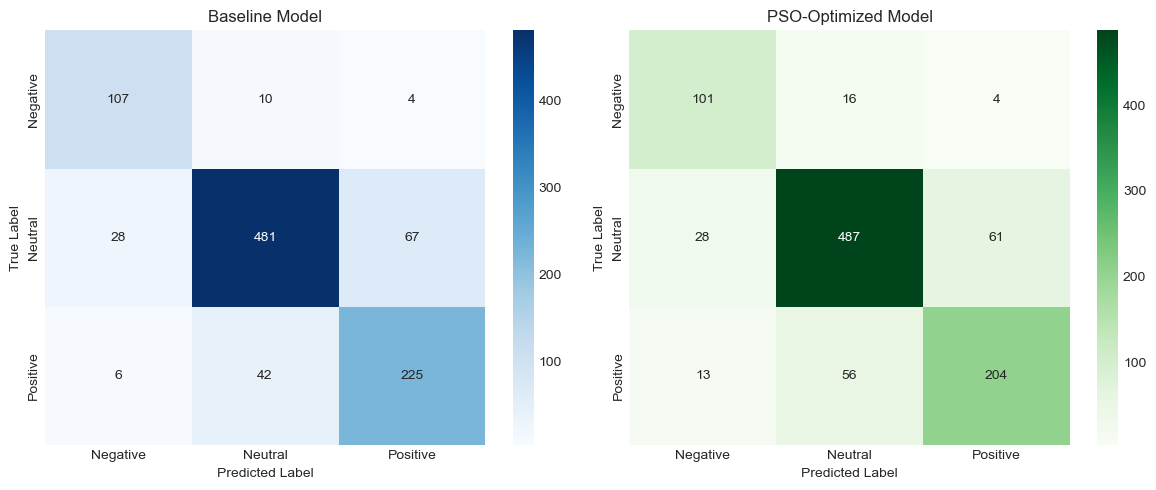

✓ Saved: confusion_matrices.png



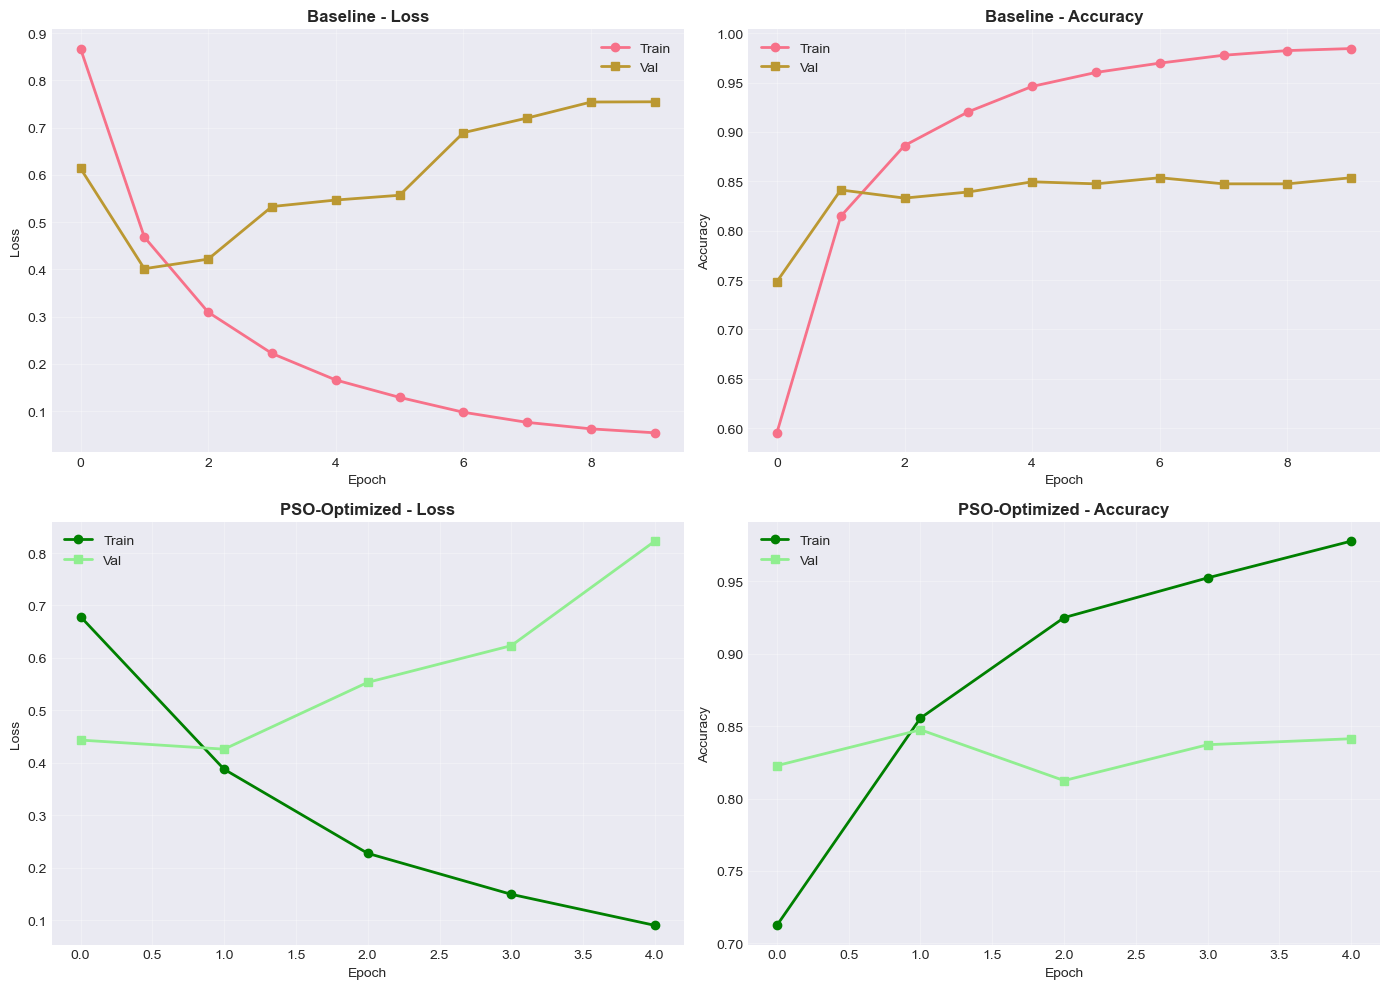

✓ Saved: training_curves.png



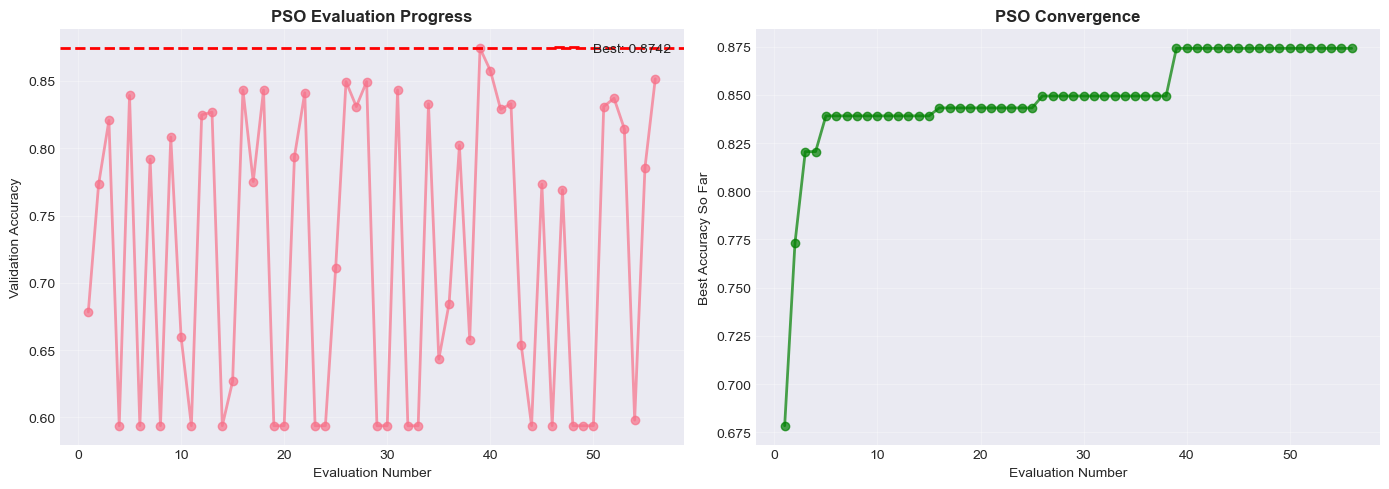

✓ Saved: pso_learning_curves.png

ERROR ANALYSIS

Per-class F1 Scores:
Class           Baseline     PSO          Change
------------------------------------------------------------
Negative        0.8168       0.7681       -0.0487
Neutral         0.8674       0.8581       -0.0093
Positive        0.7909       0.7528       -0.0381

Macro F1 - Baseline: 0.8250
Macro F1 - PSO: 0.7930
Improvement: -0.0320



In [63]:
print("="*60)
print("COMPREHENSIVE EVALUATION & VISUALIZATION")
print("="*60)
print()

# ============================================================
# TABLE I: OPTIMAL HYPERPARAMETERS
# ============================================================
print("TABLE I: OPTIMAL HYPERPARAMETERS FOUND BY PSO")
print("="*60)
print(f"{'Learning Rate':<15} {'Dropout Rate':<15} {'Hidden Layer Size'}")
print(f"{hp_optimizer.best_params['learning_rate']:>15.2e} {hp_optimizer.best_params['dropout_rate']:>15.4f} {hp_optimizer.best_params['hidden_size']:>18}")
print()
print()

# ============================================================
# TABLE II: PERFORMANCE COMPARISON
# ============================================================
print("TABLE II: PERFORMANCE COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['DistilBERT Baseline', 'DistilBERT + PSO'],
    'Test Accuracy (%)': [baseline_test_acc * 100, final_test_acc * 100],
    'Test Loss': [baseline_test_loss, final_test_loss]
})

print(comparison_df.to_string(index=False))
print()
print(f"Improvement: {improvement:+.2f} percentage points")
print("="*60)
print()
print()

# ============================================================
# CLASSIFICATION REPORTS
# ============================================================
class_names = ['Negative', 'Neutral', 'Positive']

print("="*60)
print("BASELINE - Classification Report")
print("="*60)
print(classification_report(baseline_labels, baseline_preds, target_names=class_names))
print()

print("="*60)
print("PSO-OPTIMIZED - Classification Report")
print("="*60)
print(classification_report(final_labels, final_preds, target_names=class_names))
print()

# ============================================================
# VISUALIZATION 1: CONFUSION MATRICES
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline confusion matrix
cm_baseline = confusion_matrix(baseline_labels, baseline_preds)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Baseline Model')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# PSO confusion matrix
cm_pso = confusion_matrix(final_labels, final_preds)
sns.heatmap(cm_pso, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('PSO-Optimized Model')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrices.png")
print()

# ============================================================
# VISUALIZATION 2: TRAINING CURVES
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Baseline - Loss
axes[0, 0].plot(baseline_history['train_loss'], 'o-', label='Train', linewidth=2)
axes[0, 0].plot(baseline_history['val_loss'], 's-', label='Val', linewidth=2)
axes[0, 0].set_title('Baseline - Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Baseline - Accuracy
axes[0, 1].plot(baseline_history['train_acc'], 'o-', label='Train', linewidth=2)
axes[0, 1].plot(baseline_history['val_acc'], 's-', label='Val', linewidth=2)
axes[0, 1].set_title('Baseline - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PSO - Loss
axes[1, 0].plot(final_history['train_loss'], 'o-', label='Train', linewidth=2, color='green')
axes[1, 0].plot(final_history['val_loss'], 's-', label='Val', linewidth=2, color='lightgreen')
axes[1, 0].set_title('PSO-Optimized - Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# PSO - Accuracy
axes[1, 1].plot(final_history['train_acc'], 'o-', label='Train', linewidth=2, color='green')
axes[1, 1].plot(final_history['val_acc'], 's-', label='Val', linewidth=2, color='lightgreen')
axes[1, 1].set_title('PSO-Optimized - Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_curves.png")
print()

# ============================================================
# VISUALIZATION 3: PSO LEARNING CURVES
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract PSO history
eval_nums = [h['eval'] for h in hp_optimizer.history]
val_accs = [h['val_acc'] for h in hp_optimizer.history]

# Left: All evaluations
axes[0].plot(eval_nums, val_accs, 'o-', linewidth=2, markersize=6, alpha=0.7)
axes[0].axhline(y=hp_optimizer.best_accuracy, color='r', linestyle='--', linewidth=2, 
                label=f'Best: {hp_optimizer.best_accuracy:.4f}')
axes[0].set_title('PSO Evaluation Progress', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Evaluation Number')
axes[0].set_ylabel('Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Best-so-far (convergence)
best_so_far = []
current_best = 0
for acc in val_accs:
    if acc > current_best:
        current_best = acc
    best_so_far.append(current_best)

axes[1].plot(eval_nums, best_so_far, 'o-', linewidth=2, markersize=6, 
             color='green', alpha=0.7)
axes[1].set_title('PSO Convergence', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Evaluation Number')
axes[1].set_ylabel('Best Accuracy So Far')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pso_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: pso_learning_curves.png")
print()

# ============================================================
# ERROR ANALYSIS
# ============================================================
print("="*60)
print("ERROR ANALYSIS")
print("="*60)
print()

# Per-class F1 scores
baseline_f1 = f1_score(baseline_labels, baseline_preds, average=None)
pso_f1 = f1_score(final_labels, final_preds, average=None)

print("Per-class F1 Scores:")
print(f"{'Class':<15} {'Baseline':<12} {'PSO':<12} {'Change'}")
print("-" * 60)
for i, class_name in enumerate(class_names):
    change = pso_f1[i] - baseline_f1[i]
    print(f"{class_name:<15} {baseline_f1[i]:<12.4f} {pso_f1[i]:<12.4f} {change:+.4f}")
print()

# Macro average
baseline_macro_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
pso_macro_f1 = f1_score(final_labels, final_preds, average='macro')
print(f"Macro F1 - Baseline: {baseline_macro_f1:.4f}")
print(f"Macro F1 - PSO: {pso_macro_f1:.4f}")
print(f"Improvement: {(pso_macro_f1 - baseline_macro_f1):+.4f}")
print()


## Cell 11: Save Results

In [ ]:
import pickle

# baseline results
with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

# PSO optimization results (already saved as checkpoint, but update final version)
with open('pso_optimization_results.pkl', 'wb') as f:
    pickle.dump(pso_optimization_results, f)

# final results
with open('final_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

# comparison tables
comparison_data = {
    'performance_table': comparison_df,
    'optimal_hyperparameters': hp_optimizer.best_params,
    'baseline_f1': baseline_f1,
    'pso_f1': pso_f1,
    'improvement': improvement,
    'error_reduction': error_reduction
}

with open('comparison_tables.pkl', 'wb') as f:
    pickle.dump(comparison_data, f)

# summary text file
with open('all_results_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("PSO-OPTIMIZED DISTILBERT FOR FINANCIAL SENTIMENT CLASSIFICATION\n")
    f.write("="*70 + "\n\n")
    
    f.write("DATASET INFORMATION\n")
    f.write("-" * 70 + "\n")
    f.write(f"Total samples: {len(df)}\n")
    f.write(f"Train samples: {len(train_texts)}\n")
    f.write(f"Validation samples: {len(val_texts)}\n")
    f.write(f"Test samples: {len(test_texts)}\n\n")
    
    f.write("PSO CONFIGURATION\n")
    f.write("-" * 70 + "\n")
    f.write(f"Particles: {pso_config['n_particles']}\n")
    f.write(f"Iterations: {pso_config['iters']}\n")
    f.write(f"Total evaluations: {pso_config['n_particles'] * pso_config['iters']}\n")
    
    f.write("OPTIMAL HYPERPARAMETERS (PSO)\n")
    f.write("-" * 70 + "\n")
    f.write(f"Learning Rate: {hp_optimizer.best_params['learning_rate']:.2e}\n")
    f.write(f"Dropout Rate: {hp_optimizer.best_params['dropout_rate']:.4f}\n")
    f.write(f"Hidden Size: {hp_optimizer.best_params['hidden_size']}\n\n")
    
    f.write("PERFORMANCE COMPARISON\n")
    f.write("-" * 70 + "\n")
    f.write(f"Baseline Test Accuracy: {baseline_test_acc*100:.2f}%\n")
    f.write(f"PSO-Optimized Test Accuracy: {final_test_acc*100:.2f}%\n")
    f.write(f"Improvement: {improvement:+.2f} percentage points\n")
    f.write(f"Error Reduction: {error_reduction:.1f}%\n\n")
    
    f.write(f"Baseline Macro F1: {baseline_macro_f1:.4f}\n")
    f.write(f"PSO Macro F1: {pso_macro_f1:.4f}\n")
    f.write(f"F1 Improvement: {(pso_macro_f1 - baseline_macro_f1):+.4f}\n\n")
    
    f.write("PER-CLASS F1 SCORES\n")
    f.write("-" * 70 + "\n")
    f.write(f"{'Class':<15} {'Baseline':<12} {'PSO':<12} {'Change'}\n")
    f.write("-" * 70 + "\n")
    for i, class_name in enumerate(class_names):
        change = pso_f1[i] - baseline_f1[i]
        f.write(f"{class_name:<15} {baseline_f1[i]:<12.4f} {pso_f1[i]:<12.4f} {change:+.4f}\n")

print("Final Results Summary:")
print(f"  Baseline Accuracy: {baseline_test_acc*100:.2f}%")
print(f"  PSO-Optimized Accuracy: {final_test_acc*100:.2f}%")
print(f"  Improvement: {improvement:+.2f} percentage points")
print()
print("Optimal Hyperparameters:")
print(f"  Learning Rate: {hp_optimizer.best_params['learning_rate']:.2e}")
print(f"  Dropout Rate: {hp_optimizer.best_params['dropout_rate']:.4f}")
print(f"  Hidden Size: {hp_optimizer.best_params['hidden_size']}")

Final Results Summary:
  Baseline Accuracy: 83.81%
  PSO-Optimized Accuracy: 81.65%
  Improvement: -2.16 percentage points

Optimal Hyperparameters:
  Learning Rate: 1.02e-04
  Dropout Rate: 0.2111
  Hidden Size: 386
